In [268]:
import matplotlib.pyplot as plt
import cv2 
import pytesseract
from PIL import Image
from reportlab.lib.pagesizes import A4, letter
# Adding custom options

custom_config = r'--oem 2 --psm 11 -l fra+eng'



In [269]:
A4_int = (int(round(A4[0])), int(round(A4[1])))

In [270]:
img_path = './carte-grise-specimen.jpg'

In [271]:
# img = cv2.imread('img/test1.jpg',cv2.IMREAD_UNCHANGED)
img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (A4_int[0],A4_int[1]) ,interpolation=cv2.INTER_CUBIC)
img = cv2.resize(img, None,fx=2,fy=2 ,interpolation=cv2.INTER_CUBIC)

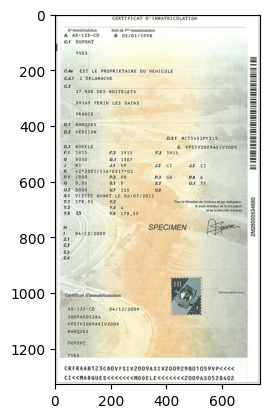

In [272]:
plt.imshow(img)

In [273]:
# cv2.imshow('image',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [274]:
# test = pytesseract.image_to_string(Image.fromarray(img), config=custom_config)
# test

In [275]:
# Perform OCR on the RGB image using pytesseract
text = pytesseract.image_to_data(Image.fromarray(img),output_type='dict',config=custom_config)

In [276]:
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i])
    #Draw box        
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

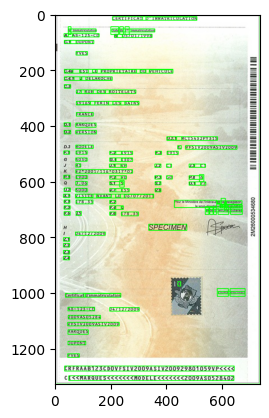

In [277]:
plt.imshow(img)

In [278]:
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i] , text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    print(x, y, w, h,chara)

0 0 736 1328 
206 9 303 13 
206 9 303 13 
206 9 303 13 
206 9 108 13 CERTIFICAT
326 10 183 12 D'IMNATRICULATION
47 53 100 11 
47 53 100 11 
47 53 100 11 
47 45 10 28 N*
56 53 91 11 ivrratriculotion
204 53 154 11 
204 53 154 11 
204 53 154 11 
200 45 28 28 Dote
232 45 13 28 de
251 45 15 28 1#*
272 53 86 11 imamotriostatien
32 70 126 12 
32 70 126 12 
32 70 126 12 
32 70 15 12 A
62 70 96 12 AB-123-CD
213 72 135 12 
213 72 135 12 
213 72 135 12 
213 72 11 12 B8
241 72 107 12 05/01/1998
33 94 106 12 
33 94 106 12 
33 94 106 12 
33 94 23 12 C1
75 94 64 12 DUPONT
75 134 41 13 
75 134 41 13 
75 134 41 13 
75 134 41 13 Yves
33 198 390 14 
33 198 390 14 
33 198 390 14 
33 198 31 13 C4a
88 198 31 13 EST
134 199 17 12 LE
165 199 127 12 PROPRIETAIRE
305 199 21 12 DU
338 200 85 12 VEHICULE
33 225 172 13 
33 225 172 13 
33 225 172 13 
33 225 35 13 C.41
89 225 7 12 2
110 225 95 12 DELAROCHE
33 253 23 13 
33 253 23 13 
33 253 23 13 
33 253 23 13 cs3
76 272 214 13 
76 272 214 13 
76 272 214 13 
76 272 

In [279]:
def adjust_text_boxes(text_data):
    # Zip the text data into tuples for easier manipulation
    boxes = list(zip([pos * A4[0] / img.shape[1] for pos in text_data['left']], 
                     [A4[1] - pos * A4[1]/img.shape[0] for pos in text_data['top']], 
                     [pos * A4[0] / img.shape[1] for pos in text_data['width']],
                       [pos * A4[1]/img.shape[0]  for pos in text_data['height']],
                         text_data['text']))

    # Sort the text boxes based on their vertical positions (top to bottom)
    sorted_boxes = sorted(boxes, key=lambda box: box[1])

    # Set a threshold for height difference to identify text on the same line
    threshold_height = 16 * A4[1]/img.shape[0]  # Adjust this value as needed
    threshold_font_size = 4
    # Correct text boxes that are too close in height
    for i in range(len(sorted_boxes) - 1):
        current_box = sorted_boxes[i]
        next_box = sorted_boxes[i + 1]

        # If the vertical distance between the current and next box is within the threshold
        if abs(current_box[1] - next_box[1]) < threshold_height:
            # Adjust the next box's top position to align it with the current box
            new_top = current_box[1]
            sorted_boxes[i + 1] = (next_box[0], new_top, next_box[2], next_box[3], next_box[4])
        if abs(current_box[3] - next_box[3]) < threshold_font_size:
                
                sorted_boxes[i + 1] = (sorted_boxes[i + 1][0], sorted_boxes[i + 1][1], sorted_boxes[i + 1][2], current_box[3], sorted_boxes[i + 1][4]) 
 

    # Unzip the corrected data
    corrected_data = {
        'left': [box[0] for box in sorted_boxes],
        'top': [box[1] for box in sorted_boxes],
        'width': [box[2] for box in sorted_boxes],
        'height': [box[3] for box in sorted_boxes],
        'text': [box[4] for box in sorted_boxes]
    }

    return corrected_data

# Example usage:
# Assuming 'text' contains the extracted text data similar to what you previously retrieved from Tesseract
corrected_text_data = adjust_text_boxes(text)

In [280]:
set(corrected_text_data["height"])

{5.705578218385353,
 6.973484489137654,
 7.607437624513805,
 8.241390759889955,
 10.143250166018406,
 10.777203301394556,
 15.21487524902761,
 15.84882838440376,
 16.48278151977991,
 17.750687790532208,
 841.8897637795276}

In [281]:
from reportlab.pdfgen import canvas

def hello(c,left,top,text,pixel):
    c.setFont("Helvetica", pixel)
    c.drawString(left,top,text,charSpace=0.25)
c = canvas.Canvas("hello.pdf")
boxes_correct = len(corrected_text_data["left"])
for i in range(boxes ):
    if corrected_text_data["text"][i] !="": 
        (x, y, w, h,chara) = (corrected_text_data['left'][i]  ,corrected_text_data['top'][i], corrected_text_data['width'][i], corrected_text_data['height'][i],corrected_text_data["text"][i])
        hello(c,x,y,chara,h)
        # c.rect(x, y, w, h-1)
c.showPage()
c.save()

In [282]:
import sys
import cv2
import numpy as np
import pytesseract
from datetime import datetime

startTime = datetime.now()

input_image_path = sys.argv[1]

img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None,fx=2,fy=2 ,interpolation=cv2.INTER_CUBIC)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
invGamma = 1.0 / 0.3
table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype(
    "uint8"
)

# apply gamma correction using the lookup table
gray = cv2.LUT(gray, table)

ret, thresh1 = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[
    -2:
]


def biggestRectangle(contours):
    biggest = True
    max_area = 0
    indexReturn = -1
    for index in range(len(contours)):
        i = contours[index]
        area = cv2.contourArea(i)
        if area > 100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.1 * peri, True)
            if area > max_area:  # and len(approx)==4:
                biggest = approx
                max_area = area
                indexReturn = index
    return indexReturn


indexReturn = biggestRectangle(contours)
hull = cv2.convexHull(contours[indexReturn])

# create a crop mask
mask = np.zeros_like(img)  # Create mask where white is what we want, black otherwise
cv2.drawContours(mask, contours, indexReturn, 255, -1)  # Draw filled contour in mask
out = np.zeros_like(img)  # Extract out the object and place into output image
out[mask == 255] = img[mask == 255]

# crop the image
(y, x, _) = np.where(mask == 255)
(topy, topx) = (np.min(y), np.min(x))
(bottomy, bottomx) = (np.max(y), np.max(x))
out = img[topy : bottomy + 1, topx : bottomx + 1, :]

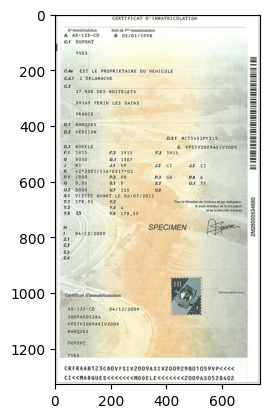

In [283]:
plt.imshow(out)

In [284]:
text = pytesseract.image_to_data(Image.fromarray(out),output_type='dict',config=custom_config)
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i] , text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    print(x, y, w, h,chara)

0 0 736 1328 
206 9 303 13 
206 9 303 13 
206 9 303 13 
206 9 108 13 CERTIFICAT
326 10 183 12 D'IMNATRICULATION
47 53 100 11 
47 53 100 11 
47 53 100 11 
47 45 10 28 N*
56 53 91 11 ivrratriculotion
204 53 154 11 
204 53 154 11 
204 53 154 11 
200 45 28 28 Dote
232 45 13 28 de
251 45 15 28 1#*
272 53 86 11 imamotriostatien
32 70 126 12 
32 70 126 12 
32 70 126 12 
32 70 15 12 A
62 70 96 12 AB-123-CD
213 72 135 12 
213 72 135 12 
213 72 135 12 
213 72 11 12 B8
241 72 107 12 05/01/1998
33 94 106 12 
33 94 106 12 
33 94 106 12 
33 94 23 12 C1
75 94 64 12 DUPONT
75 134 41 13 
75 134 41 13 
75 134 41 13 
75 134 41 13 Yves
33 198 390 14 
33 198 390 14 
33 198 390 14 
33 198 31 13 C4a
88 198 31 13 EST
134 199 17 12 LE
165 199 127 12 PROPRIETAIRE
305 199 21 12 DU
338 200 85 12 VEHICULE
33 225 172 13 
33 225 172 13 
33 225 172 13 
33 225 35 13 C.41
89 225 7 12 2
110 225 95 12 DELAROCHE
33 253 23 13 
33 253 23 13 
33 253 23 13 
33 253 23 13 cs3
76 272 214 13 
76 272 214 13 
76 272 214 13 
76 272 

In [285]:
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i])
    #Draw box        
    cv2.rectangle(out, (x, y), (x + w, y + h), (0, 255, 0), 2)

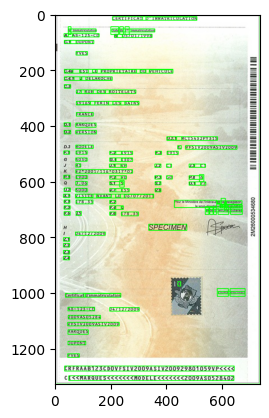

In [286]:
plt.imshow(out)

In [287]:
merge_x = 20
merge_y = 10
for i in range(boxes):
    (x, y, w, h, chara) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i], text["text"][i])

    # Check if the coordinates match the region of interest
    if (x >= 50-merge_x and x <= merge_x+50) and (y >= 60-merge_y and y<=60+merge_y) :
        target_text = chara
print(target_text)

AB-123-CD


In [292]:
import re
text = " ".join(text["text"])
# Define the regex pattern
pattern = r'[A-Z]{2}-\d{3}-[A-Z]{2}'

# Search for the pattern in the text
match = re.search(pattern, text)

# If a match is found, print the result
if match:
    print(f"N. d'immatriculation  : {match.group()}")


# Define the regex pattern for the date
date_pattern = r'\b\d{2}/\d{2}/\d{4}\b'

# Find all occurrences of the date pattern in the text
date_matches = re.findall(date_pattern, text)

# Print the list of matches
print(f"Date de 1er immarticulation : {date_matches[0]}")
print(f"Visite avant le  : {date_matches[1]}")
print(f"Date d'immarticulation actuelle  : {date_matches[2]}")

N. d'immatriculation  : AB-123-CD
Date de 1er immarticulation : 05/01/1998
Visite avant le  : 06/07/2011
Date d'immarticulation actuelle  : 04/12/2009
